In [19]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from keras.models import Sequential
import tensorflow as tf
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.layers import LSTM, Dense
from keras.layers import GRU 
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, Flatten, MultiHeadAttention
from tensorflow.keras.models import Model
def adj_r2_score(r2, n, k):
    return 1-((1-r2)*((n-1)/(n-k-1)))

In [20]:
exchange_data = pd.read_csv('GBPUSD-4HOUR.csv')
exchange_data.head()

,time,open,high,low,close,Volume,Volume MA
0,2009-12-31T22:00:00Z,1.617570,1.617570,1.615630,1.615630,8,NaN
1,2010-01-03T22:00:00Z,1.611220,1.615290,1.609180,1.609230,4115,NaN
2,2010-01-04T02:00:00Z,1.609230,1.612080,1.607350,1.609630,2782,NaN
3,2010-01-04T06:00:00Z,1.609630,1.621375,1.605795,1.620535,7412,NaN
4,2010-01-04T10:00:00Z,1.620535,1.624185,1.613925,1.616265,8100,NaN


In [21]:
exchange_data["time"] = pd.to_datetime(exchange_data["time"])
ind_exchange_data = exchange_data.set_index(["time"], drop=True)
ind_exchange_data.head()

,open,high,low,close,Volume,Volume MA
time,,,,,,
2009-12-31 22:00:00+00:00,1.617570,1.617570,1.615630,1.615630,8,NaN
2010-01-03 22:00:00+00:00,1.611220,1.615290,1.609180,1.609230,4115,NaN
2010-01-04 02:00:00+00:00,1.609230,1.612080,1.607350,1.609630,2782,NaN
2010-01-04 06:00:00+00:00,1.609630,1.621375,1.605795,1.620535,7412,NaN
2010-01-04 10:00:00+00:00,1.620535,1.624185,1.613925,1.616265,8100,NaN


In [22]:
data_frame = ind_exchange_data.sort_index(axis=1 ,ascending=False)

cut_off_date = pd.Timestamp('22-05-22')
data_frame = data_frame.loc[:cut_off_date]
clipped_length = len(data_frame)
data_frame.tail(10)

/var/folders/qs/tq01j0l577ddz8gg_tnvhl6m0000gn/T/ipykernel_95111/4232442468.py:4: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version. Use a timezone-aware object instead.
  data_frame = data_frame.loc[:cut_off_date]


,open,low,high,close,Volume MA,Volume
time,,,,,,
2022-05-19 05:00:00+00:00,1.23864,1.23378,1.24077,1.23918,32155.10,42788
2022-05-19 09:00:00+00:00,1.23918,1.23696,1.24381,1.24292,33082.85,48980
2022-05-19 13:00:00+00:00,1.24292,1.24264,1.25248,1.24984,35075.50,77473
2022-05-19 17:00:00+00:00,1.24984,1.24710,1.25122,1.24713,35395.15,37673
2022-05-19 21:00:00+00:00,1.24713,1.24510,1.24844,1.24637,33937.35,15466
2022-05-20 01:00:00+00:00,1.24637,1.24370,1.24696,1.24544,34148.55,26153
2022-05-20 05:00:00+00:00,1.24544,1.24480,1.24968,1.24868,35528.95,39773
2022-05-20 09:00:00+00:00,1.24868,1.24614,1.24908,1.24784,36202.25,31684
2022-05-20 13:00:00+00:00,1.24784,1.24526,1.25004,1.24721,36749.65,52058


In [23]:
print("The length of the original dataset it", len(ind_exchange_data))
print("The length of the clipped dataset is", len(data_frame))

The length of the original dataset it 20438
The length of the clipped dataset is 19270


<AxesSubplot: xlabel='time'>

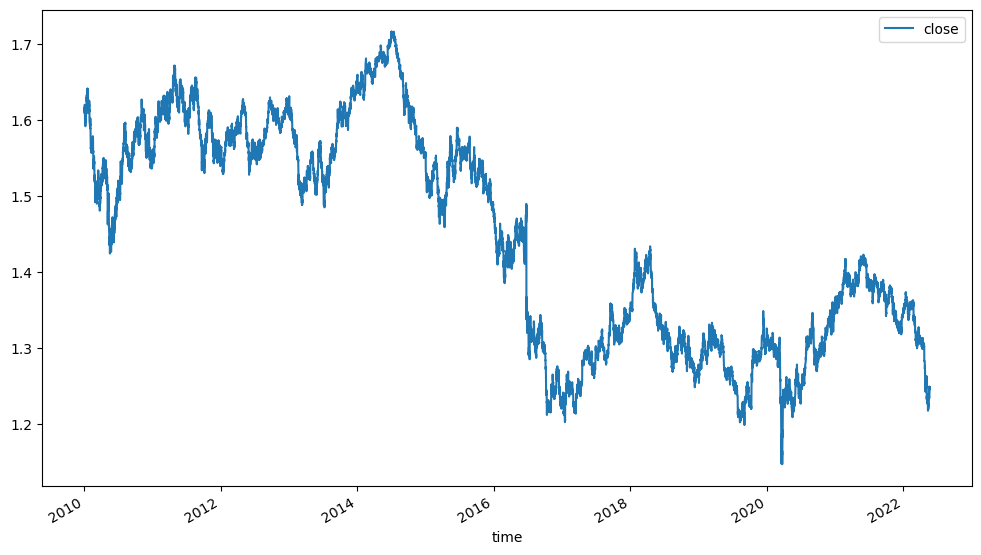

In [24]:
df = data_frame[["close"]]

#plotting dataset to visualize the pattern of prices over the years

df.plot(kind='line',figsize=(12,7))

In [25]:
diff = df.index.values[-1] - df.index.values[0]
days = diff.astype('timedelta64[D]')
days = days / np.timedelta64(1, 'D')
years = int(days/365)
print("Total data: %d years"%years)
print("80 percent data = 2010 to %d"%(2010 + int(0.8*years)))

Total data: 12 years
80 percent data = 2010 to 2019


In [26]:
df.describe()

,close
count,19270.000000
mean,1.445136
std,0.142216
min,1.147640
25%,1.309480
50%,1.441470
75%,1.572085
max,1.717000


In [27]:
#deduce where the number where the partition should be made 

adjust_data_frame = np.array(data_frame)
x = int(len(data_frame))
split_length = int(x * 0.8)
#You need find the data where the training and testing will be split
split_date = data_frame.index[split_length]



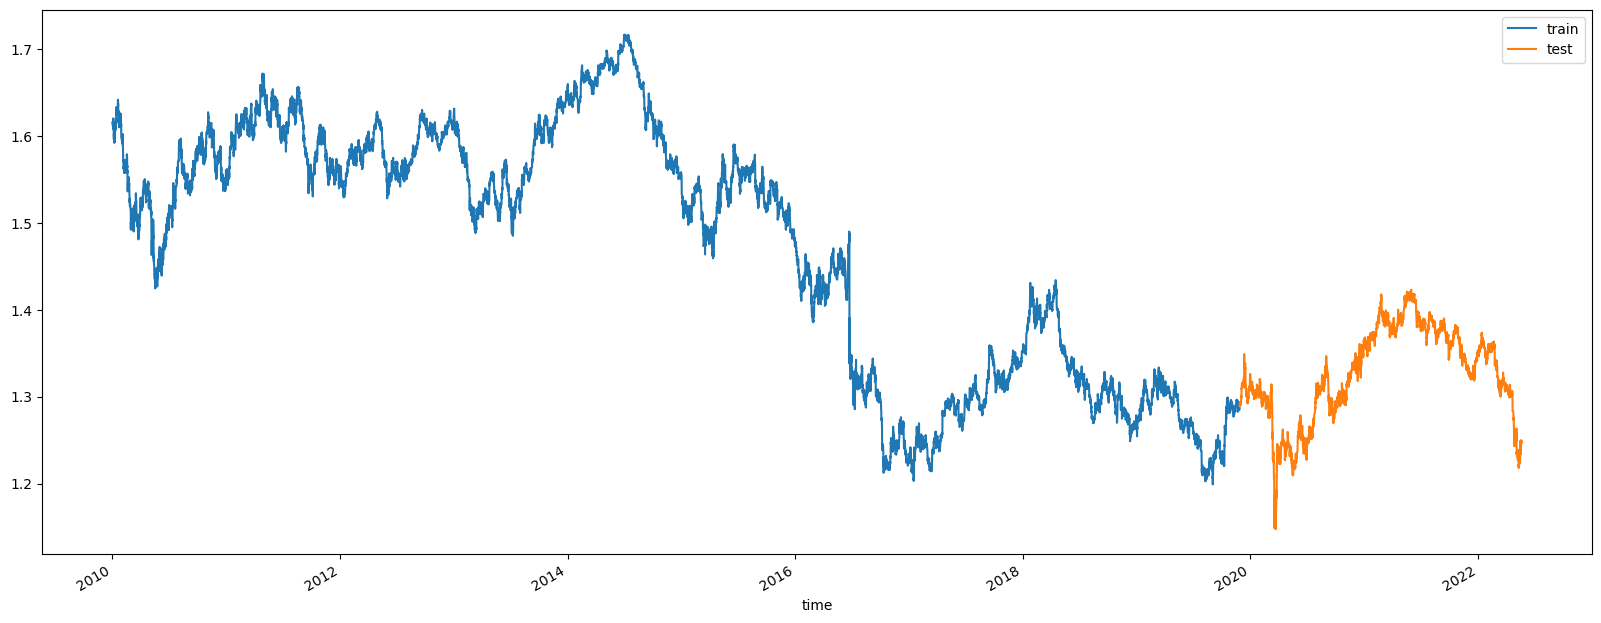

In [28]:
train = df.loc[:split_date]
test = df.loc[split_date:]

ax = train.plot(kind='line',figsize=(20,8))
test.plot(ax=ax,kind='line',figsize=(20,8))
plt.legend(['train', 'test'])

In [29]:
sc = StandardScaler()
train_sc = sc.fit_transform(train)
test_sc = sc.transform(test)

In [30]:
X_train = train_sc[:-1]
y_train = train_sc[1:]

X_test = test_sc[:-1]
y_test = test_sc[1:]


In [31]:
X = []
y = []
timesteps = 6

for i in range(timesteps, train.shape[0]):
    X.append(train_sc[i-timesteps:i, 0])
    y.append(train_sc[i, 0])



X = np.array(X)
y = np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))

print(X.shape)
print(y.shape)






(15411, 6, 1)
(15411,)


In [37]:
input_shape = (6,)
d_model = 64
num_heads = 4
num_layers = 2
dropout_rate = 0.2

# Define model architecture
inputs = Input(shape=input_shape)
x = Embedding(input_dim=input_shape[0], output_dim=d_model)(inputs)
for i in range(num_layers):
    x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.LayerNormalization()(x)
    x = Dense(units=d_model, activation='relu')(x)
    x = Dropout(dropout_rate)(x)
    x = tf.keras.layers.LayerNormalization()(x)
outputs = Dense(units=1, activation='linear')(x)

# Compile model
model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer='adam', loss='mse')

In [38]:
model.compile(loss=tf.keras.metrics.mean_squared_error,
              metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse')], optimizer='adam')
early_stop = EarlyStopping(monitor='loss', patience=5, verbose=1)
#there may be a potiental error in this, change y_train???
history_model_lstm = model.fit(X, y, epochs=100, batch_size=200, verbose=1, shuffle=False, callbacks=[early_stop])

Epoch 1/100
49/78 [=================>............] - ETA: 0s - loss: 0.8431 - rmse: 0.9182

InvalidArgumentError: Graph execution error:

Detected at node 'model_1/embedding_4/embedding_lookup' defined at (most recent call last):
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell
      result = self._run_cell(
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell
      result = runner(coro)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/var/folders/qs/tq01j0l577ddz8gg_tnvhl6m0000gn/T/ipykernel_95111/410885666.py", line 5, in <module>
      history_model_lstm = model.fit(X, y, epochs=100, batch_size=200, verbose=1, shuffle=False, callbacks=[early_stop])
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 1409, in fit
      tmp_logs = self.train_function(iterator)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 1051, in train_function
      return step_function(self, iterator)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 1040, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 1030, in run_step
      outputs = model.train_step(data)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 889, in train_step
      y_pred = self(x, training=True)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/functional.py", line 458, in call
      return self._run_internal_graph(
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "/Users/yaminchoudhury/miniforge3/envs/Project/lib/python3.10/site-packages/keras/layers/core/embedding.py", line 199, in call
      out = tf.nn.embedding_lookup(self.embeddings, inputs)
Node: 'model_1/embedding_4/embedding_lookup'
indices[182,0] = -1 is not in [0, 6)
	 [[{{node model_1/embedding_4/embedding_lookup}}]] [Op:__inference_train_function_12560]

In [637]:
X_test_lstm = []
Y_test_lstm = []

for i in range(timesteps, test.shape[0]):
    X_test_lstm.append(test_sc[i-timesteps:i, 0])
    Y_test_lstm.append(test_sc[i, 0])

    
X_test_lstm = np.array(X_test_lstm)
Y_test_lstm = np.array(Y_test_lstm)
X_test_lstm = np.reshape(X_test_lstm, (X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

y_pred_test_lstm = model_lstm.predict(X_test_lstm)





print(sc.inverse_transform(Y_test_lstm[-1].reshape(-1,1)))




121/121 [==============================] - 0s 904us/step
[[1.24918]]


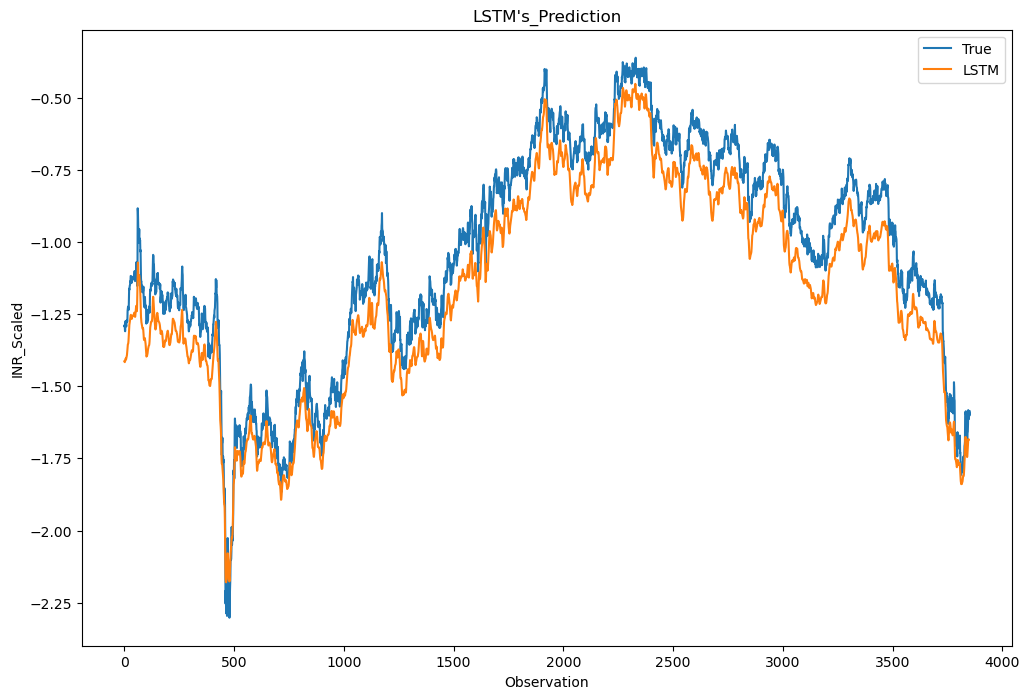

In [638]:
plt.figure(figsize=(12,8))
plt.plot(y_test, label='True')
plt.plot(y_pred_test_lstm, label='LSTM')
plt.title("LSTM's_Prediction")
plt.xlabel('Observation')
plt.ylabel('INR_Scaled')
plt.legend()
plt.show()

In [639]:
last_prediction = y_pred_test_lstm[-timesteps:]
last_prediction = np.array(last_prediction)

for i in range(10):
    next_input = np.array([last_prediction[-timesteps:]])
    next_input = next_input.reshape((next_input.shape[0], next_input.shape[1], 1))
    next_prediction = model_lstm.predict(next_input, verbose=0)
    last_prediction = np.append(last_prediction, next_prediction[0])
    

lstm_future = np.array(last_prediction[-10:]).reshape(-1,1)
inverse_transformed_data_lstm = sc.inverse_transform(lstm_future).flatten().tolist()
print(inverse_transformed_data_lstm)








[1.2237292528152466, 1.2246545553207397, 1.2245936393737793, 1.2230268716812134, 1.2206764221191406, 1.2182759046554565, 1.2162432670593262, 1.2155028581619263, 1.2141715288162231, 1.2125649452209473]


In [640]:
lstm_rounded_numbers = [round(x, 5) for x in inverse_transformed_data_lstm]

#The last predicted value from the lstm test data 
print(sc.inverse_transform(y_pred_test_lstm[-1:]))
#The next predicitons made by the model 
print(lstm_rounded_numbers)


#So in terms of prediction we have the very last of the testing data plus the new iterations 

[[1.2352633]]
[1.22373, 1.22465, 1.22459, 1.22303, 1.22068, 1.21828, 1.21624, 1.2155, 1.21417, 1.21256]


In [641]:
future_lstm_prices = []
last_lstm = sc.inverse_transform(y_pred_test_lstm[-1:])
future_lstm_prices.append(round(float(last_lstm[0]),5))
for x in lstm_rounded_numbers:
    future_lstm_prices.append(x) 

In [642]:
print(clipped_length)
future_comparison = ind_exchange_data.iloc[clipped_length-1:]
print(future_comparison.head(10))             

19270
                              open     high      low    close  Volume  \
time                                                                    
2022-05-20 17:00:00+00:00  1.24721  1.24970  1.24533  1.24918   29134   
2022-05-22 21:00:00+00:00  1.24918  1.25300  1.24795  1.25263   14233   
2022-05-23 01:00:00+00:00  1.25263  1.25534  1.25222  1.25460   18129   
2022-05-23 05:00:00+00:00  1.25460  1.25759  1.25412  1.25717   39832   
2022-05-23 09:00:00+00:00  1.25717  1.26010  1.25634  1.25676   36437   
2022-05-23 13:00:00+00:00  1.25676  1.25938  1.25562  1.25684   43402   
2022-05-23 17:00:00+00:00  1.25684  1.25888  1.25584  1.25879   18767   
2022-05-23 21:00:00+00:00  1.25879  1.25890  1.25568  1.25590   11758   
2022-05-24 01:00:00+00:00  1.25590  1.25696  1.25475  1.25606   16979   
2022-05-24 05:00:00+00:00  1.25606  1.25991  1.24750  1.24866   46084   

                           Volume MA  
time                                  
2022-05-20 17:00:00+00:00   35497.20  


In [643]:
future = future_comparison.iloc[0:11]

future_prices_table = future["close"]

future_prices = []
for x in future_prices_table:
    future_prices.append(x)

print(future_prices)

[1.24918, 1.25263, 1.2546, 1.25717, 1.25676, 1.25684, 1.25879, 1.2559, 1.25606, 1.24866, 1.2492]


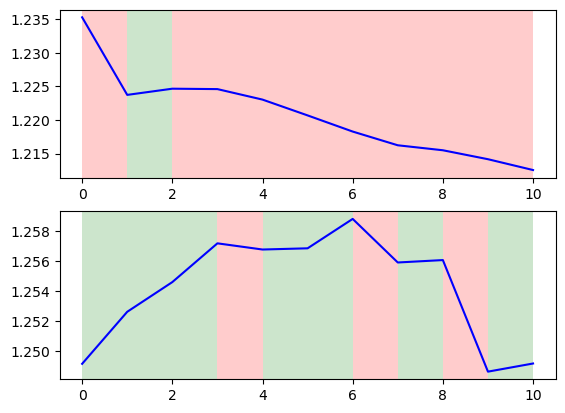

In [644]:

def classify_numbers(lst):
    classifications = []
    prev_num = lst[0]
    for i, num in enumerate(lst[1:], start=1):
        if num > prev_num:
            classifications.append('green')
        else:
            classifications.append('red')
        prev_num = num
    return classifications

classifications1 = classify_numbers(future_lstm_prices)
classifications2 = classify_numbers(future_prices)

fig, (ax1, ax2) = plt.subplots(2, 1)

ax1.plot(future_lstm_prices, color='blue')
for i, c in enumerate(classifications1):
    if c == 'green':
        ax1.axvspan(i, i+1, facecolor='green', alpha=0.2)
    elif c == 'red':
        ax1.axvspan(i, i+1, facecolor='red', alpha=0.2)

ax2.plot(future_prices, color='blue')
for i, c in enumerate(classifications2):
    if c == 'green':
        ax2.axvspan(i, i+1, facecolor='green', alpha=0.2)
    elif c == 'red':
        ax2.axvspan(i, i+1, facecolor='red', alpha=0.2)

plt.show()



#This may be potientally be abled to be used, it may have not got the correct retracements however it was able to predict the overall direction, 
#say you have had a fib at this level for a potiental buy this fib could be immediately discarded as it will be clear break through, we need to find a potiental change 
#in momentum to be able to predict this. Evaluation wise these model might do well in predictiing overall trend than proper values  




In [ ]:
#Things to do, you need to add different time frames, you also need to include different features 